# 3 Diagnostics

In this notebook we will look at some of the results produced by the gen2 pipeline run. We will compare these to the tile catalogues as well as the public catalogues in HELP. We will also experiemnt with stitching patch catalogues together.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack
import astropy.units as u

import os
from collections import OrderedDict
import yaml
import glob
import numpy as np

import matplotlib.pyplot as plt

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

import warnings
warnings.filterwarnings('ignore')

In [2]:
OXFORD_VISTA_Ks_CAT = "../../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"
ks_tile_file = '../../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00133_st_tl_cat.fits' #sxds
# '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20171027/v20171027_00181_st_tl_cat.fits' #sxds
y_tile_file = '../../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00088_st_tl_cat.fits' #sxds
# '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00130_st_tl_cat.fits' #sxds
# '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00172_st_tl_cat.fits' #sxds
# '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00214_st_tl_cat.fits' #sxds

In [3]:
def flux_to_mag(fluxes, errors_on_fluxes=None):
    """Convert fluxes and errors to magnitudes
    Given flux densities in Jy with associated errors, this function returns
    the corresponding AB magnitudes en errors.
    The magnitudes are computed with this formula:
        M = 2.5 * (23 - log10(F)) - 48.6
    and the errors on magnitudes with this one
        M_err = 2.5/ln(10) * F_err / F
    Parameters
    ----------
    fluxes: float or array-like of floats
        The fluxes in Jy.
    errors_on_fluxes: float or array-like of floats
        The flux errors in Jy None if there are no errors.
    Returns
    -------
    magnitudes: float or array-like of floats
        The AB magnitudes.
    errors: float or array-like of floats
        The errors on AB magnitudes.
    """
    fluxes = np.array(fluxes)
    magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6

    if errors_on_fluxes is not None:
        errors_on_fluxes = np.array(errors_on_fluxes)
        errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
    else:
        errors = None

    return magnitudes, errors

## 3.1 ProcessCcd fails

A number of ccds fail with the error IndexError("No viable PSF candidates survive")

e.g.

dataId={'dateObs': '2017-10-27', 'visit': 614785, 'filter': 'VISTA-Y', 'hdu': 9, 'ccdnum': 8, 'ccd': 8}

Are these bad exposures which shoudl fail or not?

In [4]:
def cutout_scale(im, num_min = 2.0, num_max = 5.0):
    """
    Takes an image array and returns the vmin and vmax required to scale the image 
    between median + 5 * sigma MAD and median - 2 * sigma MAD
    """

    import numpy as np
    import astropy.stats as apys

    data = im.flatten()   #Return a copy of the array collapsed into one dimension

    try:
        med = np.median(data[np.isnan(data)!=1])
        sigma_MAD = apys.mad_std(data[np.isnan(data)!=1])
    except IndexError:
        med = 0.0
        sigma_MAD = 0.0
    vmax = med + num_max * sigma_MAD
    vmin = med - num_min * sigma_MAD

    return vmin, vmax
def plot_fits(im_hdu):
    wcs = WCS(im_hdu.header)
    #wcs = WCS(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00266_st.fit')
    vmin, vmax = cutout_scale(im_hdu.data)
    
    plt.subplot(projection=wcs)

    plt.imshow(im_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.grid(color='white', ls='solid')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')

In [5]:
dataId={'dateObs': '2017-10-27', 'obsNum': '00133', 
        'visit': 614753, 'filter': 'VISTA-Y', 'hdu': 9, 'ccdnum': 8, 'ccd': 8}

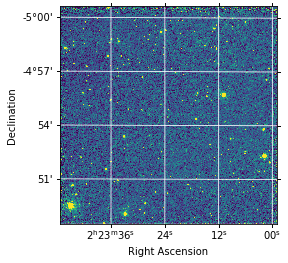

In [6]:
f = fits.open('./data/raw/{}/{}-{}-{}.fits'.format(
        dataId['dateObs'],  dataId['visit'], dataId['obsNum'],dataId['filter']))
plot_fits(f[dataId['hdu']])

It is not clear to me why no PSF candidates are usable from this. Perhaps I need to further tinker with the star selector config options.

## 3.2 Catalogs

The first thing we need to do is combine all the catalogues and compare to the legacy VISTA photometry which will come from two sources.

There are the final catalogues merged from individual tiles, secondly there are the tile catalogues themselves

### 3.2.1 Tile catalogues

From discussion with Carlos, magnitude should be calculated from these catalogues using:

mag = header['MAZPT'] - 2.5 * log10(data['Aper_flux_3']/header['EXPTIME']) - header['APCOR3']

In [7]:
ks_tile_cat = Table.read(ks_tile_file)
ks_magzpt = fits.open(ks_tile_file)[1].header['MAGZPT']
ks_exptime = fits.open(ks_tile_file)[1].header['EXPTIME']
ks_apcor3 = fits.open(ks_tile_file)[1].header['APCOR3']
ks_tile_cat['m_vista_ks'] = ks_magzpt - 2.5 * np.log10(ks_tile_cat['Aper_flux_3']/ks_exptime) - ks_apcor3
ks_tile_cat['merr_vista_ks'] = (2.5 / np.log(10))* (ks_tile_cat['Aper_flux_3_err'] / ks_tile_cat['Aper_flux_3'])
for c in ks_tile_cat.colnames:
    ks_tile_cat[c].name = 'ks_tile_' + c
y_tile_cat = Table.read(y_tile_file)
y_magzpt = fits.open(y_tile_file)[1].header['MAGZPT']
y_exptime = fits.open(y_tile_file)[1].header['EXPTIME']
y_apcor3 = fits.open(y_tile_file)[1].header['APCOR3']
y_tile_cat['m_vista_y'] = y_magzpt - 2.5 * np.log10(y_tile_cat['Aper_flux_3']/y_exptime) - y_apcor3
y_tile_cat['merr_vista_y'] = (2.5 / np.log(10))* (y_tile_cat['Aper_flux_3_err'] / y_tile_cat['Aper_flux_3'])
for c in y_tile_cat.colnames:
    y_tile_cat[c].name = 'y_tile_' + c
y_tile_cat['y_tile_RA'].unit = u.rad
y_tile_cat['y_tile_DEC'].unit = u.rad
ks_tile_cat['ks_tile_RA'].unit = u.rad
ks_tile_cat['ks_tile_DEC'].unit = u.rad

In [8]:
y_tile_cat[:10].show_in_notebook()

idx,y_tile_Sequence_number,y_tile_Isophotal_flux,y_tile_X_coordinate,y_tile_X_coordinate_err,y_tile_Y_coordinate,y_tile_Y_coordinate_err,y_tile_Gaussian_sigma,y_tile_Ellipticity,y_tile_Position_angle,y_tile_Areal_1_profile,y_tile_Areal_2_profile,y_tile_Areal_3_profile,y_tile_Areal_4_profile,y_tile_Areal_5_profile,y_tile_Areal_6_profile,y_tile_Areal_7_profile,y_tile_Areal_8_profile,y_tile_Peak_height,y_tile_Peak_height_err,y_tile_Aper_flux_1,y_tile_Aper_flux_1_err,y_tile_Aper_flux_2,y_tile_Aper_flux_2_err,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_Aper_flux_4,y_tile_Aper_flux_4_err,y_tile_Aper_flux_5,y_tile_Aper_flux_5_err,y_tile_Aper_flux_6,y_tile_Aper_flux_6_err,y_tile_Aper_flux_7,y_tile_Aper_flux_7_err,y_tile_Aper_flux_8,y_tile_Aper_flux_8_err,y_tile_Aper_flux_9,y_tile_Aper_flux_9_err,y_tile_Aper_flux_10,y_tile_Aper_flux_10_err,y_tile_Aper_flux_11,y_tile_Aper_flux_11_err,y_tile_Aper_flux_12,y_tile_Aper_flux_12_err,y_tile_Aper_flux_13,y_tile_Aper_flux_13_err,y_tile_Petr_radius,y_tile_Kron_radius,y_tile_Half_radius,y_tile_Petr_flux,y_tile_Petr_flux_err,y_tile_Kron_flux,y_tile_Kron_flux_err,y_tile_Half_flux,y_tile_Half_flux_err,y_tile_Error_bit_flag,y_tile_Sky_level,y_tile_Sky_rms,y_tile_Av_conf,y_tile_RA,y_tile_DEC,y_tile_Classification,y_tile_Statistic,y_tile_MJDoff,y_tile_Blank64,y_tile_Blank65,y_tile_Blank66,y_tile_Blank67,y_tile_Blank68,y_tile_Blank69,y_tile_Blank70,y_tile_Blank71,y_tile_Blank72,y_tile_Blank73,y_tile_Blank74,y_tile_Blank75,y_tile_Blank76,y_tile_Blank77,y_tile_Blank78,y_tile_Blank79,y_tile_Blank80,y_tile_m_vista_y,y_tile_merr_vista_y
,Number,ADU,Pixels,Pixels,Pixels,Pixels,Pixels,Number,Degrees,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,ADU,Pixels,Pixels,Pixels,ADU,ADU,ADU,ADU,ADU,ADU,Number,ADU,ADU,Number,rad,rad,Flag,N-sigma,Minutes,Blank64,Blank65,Blank66,Blank67,Blank68,Blank69,Blank70,Blank71,Blank72,Blank73,Blank74,Blank75,Blank76,Blank77,Blank78,Blank79,Blank80,ADU,ADU
0,1.0,921.8867,4983.0273,0.05984435,9.388772,0.0624089,1.9808085,0.48485237,107.30793,20.0,19.0,11.0,4.0,0.0,0.0,0.0,0.0,86.71671,7.3892465,400.0605,18.651834,661.95105,27.309013,871.09937,38.55914,1078.5931,53.743656,1129.4828,74.6175,1134.938,104.31876,1217.9147,146.308,1413.6171,182.66167,1696.7389,219.04274,1749.0302,255.33528,1794.242,291.64743,2176.6206,364.39105,2196.0547,437.05936,5.533835,2.616285,1.8139688,1193.9323,135.08351,1140.8403,65.18942,562.01135,24.368742,3.6772914,12936.035,0.030761719,14.0361395,0.6222503,-0.07115458,1.0,6.5184035,102.84366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.046965,0.04806002
1,2.0,688.3877,4508.7407,0.0890093,15.280858,0.09162233,2.0142353,0.45026088,103.68572,24.0,19.0,6.0,0.0,0.0,0.0,0.0,0.0,57.771984,7.0745635,288.9105,18.22838,453.50153,26.615112,661.6207,38.020866,866.3981,53.318455,987.51495,74.40703,1157.943,104.30012,1376.4124,146.46542,1459.3898,182.6157,2308.611,219.23123,4122.256,256.14407,5061.0483,292.62817,5200.8555,365.06094,4579.3384,437.42325,6.5410166,4.2627363,2.228508,1389.531,159.43713,1162.0294,104.44083,491.33652,28.737587,0.0,12935.821,0.013671875,28.842001,0.62303716,-0.071162604,1.0,7.1863885,104.944695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.34561,0.062393192
2,3.0,725.63965,4350.1426,0.06778934,17.722576,0.06712905,1.5464351,0.16796577,156.10849,19.0,17.0,8.0,1.0,0.0,0.0,0.0,0.0,78.97997,7.370695,381.69626,18.763563,583.8084,27.103569,744.45734,38.230984,799.3838,53.171967,915.08356,74.29788,1010.00226,104.136696,1000.65735,146.25589,885.21985,182.26584,784.0714,218.49963,988.1723,254.88593,1253.455,291.2857,1327.0056,363.93756,4585.014,437.3232,4.0335813,2.4700708,1.6411198,1000.2405,98.76382,825.8873,61.204853,455.27637,22.013323,0.0,12935.787,0.00390625,42.024292,0.62330025,-0.07116606,1.0,4.1150656,106.41388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
ra_min = np.min(y_tile_cat['y_tile_RA'].to(u.deg))
ra_max = np.max(y_tile_cat['y_tile_RA'].to(u.deg))
dec_min = np.min(y_tile_cat['y_tile_DEC'].to(u.deg))
dec_max = np.max(y_tile_cat['y_tile_DEC'].to(u.deg))
print("{} < ra < {}, {} < dec < {}".format(
    ra_min,
ra_max,
dec_min,
dec_max
))

34.91555404663086 deg < ra < 36.12733840942383 deg, -5.558224678039551 deg < dec < -4.076857089996338 deg


(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 6.000e+00,
        6.000e+00, 2.000e+01, 1.200e+01, 1.500e+01, 2.200e+01, 1.900e+01,
        2.500e+01, 2.300e+01, 1.600e+01, 2.300e+01, 2.700e+01, 3.600e+01,
        2.400e+01, 3.800e+01, 3.100e+01, 3.200e+01, 2.700e+01, 2.800e+01,
        3.400e+01, 3.400e+01, 2.700e+01, 3.600e+01, 3.900e+01, 3.600e+01,
        4.600e+01, 5.600e+01, 4.300e+01, 4.800e+01, 4.700e+01, 4.400e+01,
        6.400e+01, 6.300e+01, 7.100e+01, 7.900e+01, 6.200e+01, 9.400e+01,
        8.700e+01, 9.000e+01, 9.800e+01, 1.150e+02, 1.120e+02, 1.260e+02,
        1.450e+02, 1.710e+02, 1.690e+02, 1.800e+02, 2.110e+02, 2.190e+02,
        2.470e+02, 2.490e+02, 2.880e+02, 3.210e+02, 3.770e+02, 3.770e+02,
        4.140e+02, 4.480e+02, 5.160e+02, 5.600e+02, 6.340e+02, 7.010e+02,
        8.460e+02, 8.980e+02, 1.004e+03, 1.101e+03, 1.256e+03, 1.296e+03,
        1.368e+03, 1.555e+03, 1.742e+03, 1.832e+03, 2.017e+03, 2.135e+03,
        2.267e+03, 2.424e+03, 2.578e+0

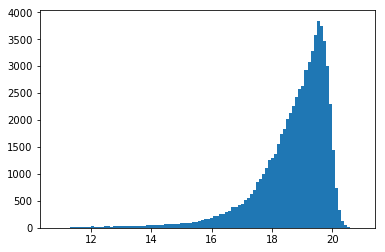

In [10]:
plt.hist(y_tile_cat['y_tile_m_vista_y'], bins=100)

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.600e+01,
        1.400e+01, 1.400e+01, 3.000e+01, 2.500e+01, 2.700e+01, 1.700e+01,
        1.500e+01, 2.000e+01, 1.500e+01, 2.500e+01, 2.700e+01, 1.700e+01,
        2.100e+01, 1.600e+01, 2.900e+01, 2.900e+01, 2.800e+01, 3.400e+01,
        3.700e+01, 3.200e+01, 4.300e+01, 4.700e+01, 3.600e+01, 3.400e+01,
        3.400e+01, 4.800e+01, 5.600e+01, 6.700e+01, 5.000e+01, 6.900e+01,
        6.400e+01, 6.600e+01, 7.800e+01, 9.100e+01, 8.800e+01, 7.500e+01,
        9.700e+01, 9.300e+01, 1.060e+02, 1.220e+02, 1.000e+02, 1.280e+02,
        1.470e+02, 1.250e+02, 1.870e+02, 1.660e+02, 2.000e+02, 2.090e+02,
        2.440e+02, 2.500e+02, 2.810e+02, 2.930e+02, 3.310e+02, 3.610e+02,
        4.340e+02, 4.160e+02, 4.640e+02, 6.060e+02, 5.970e+02, 6.830e+02,
        7.610e+02, 8.750e+02, 9.970e+02, 1.121e+03, 1.233e+03, 1.295e+03,
        1.496e+03, 1.688e+03, 1.893e+03, 2.054e+03, 2.312e+03, 2.583e+03,
        2.739e+03, 3.053e+03, 3.262e+0

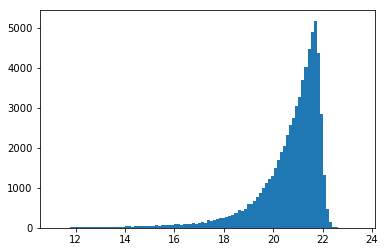

In [11]:
plt.hist(ks_tile_cat['ks_tile_m_vista_ks'], bins=100)

### 3.2.2 HELP catalogues

These are the official final catalogues and could be a useful second check

In [12]:
imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'ra', 
        'DELTA_J2000':     'dec', 
        'J_CLASS_STAR':    'vista_stellarity', 
        'Y_MAG_APER_3':    'm_ap_vista_y', 
        'Y_MAGERR_APER_3': 'merr_ap_vista_y', 
        'Y_MAG_AUTO':      'm_vista_y', 
        'Y_MAGERR_AUTO':   'merr_vista_y',
        'Y_FLUX_APER_3':   'f_ap_vista_y', 
        'Y_FLUXERR_APER_3':'ferr_ap_vista_y', 
        'Y_FLUX_AUTO':     'f_vista_y', 
        'Y_FLUXERR_AUTO':  'ferr_vista_y',
  
        'K_MAG_APER_3':    'm_ap_vista_ks', 
        'K_MAGERR_APER_3': 'merr_ap_vista_ks', 
        'K_MAG_AUTO':      'm_vista_ks', 
        'K_MAGERR_AUTO':   'merr_vista_ks',

})


help_cat = Table.read("../../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_XMM-LSS.fits"
                      )[list(imported_columns)]
for column in imported_columns:
    help_cat[column].name = 'help_' + imported_columns[column]
help_cat['help_ra'].unit = u.deg
help_cat['help_dec'].unit = u.deg
help_cat['help_ra'].convert_unit_to(u.rad)
help_cat['help_dec'].convert_unit_to(u.rad)

(array([1.0000e+00, 3.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00,
        8.0000e+00, 9.0000e+00, 1.5000e+01, 1.9000e+01, 2.6000e+01,
        2.5000e+01, 2.5000e+01, 2.8000e+01, 4.5000e+01, 3.7000e+01,
        3.6000e+01, 5.4000e+01, 6.0000e+01, 7.1000e+01, 6.9000e+01,
        7.2000e+01, 8.2000e+01, 1.2200e+02, 1.2300e+02, 1.3100e+02,
        1.6500e+02, 1.7200e+02, 1.9500e+02, 2.4000e+02, 2.7000e+02,
        3.3700e+02, 3.7100e+02, 4.1700e+02, 5.1000e+02, 5.7100e+02,
        7.5700e+02, 8.5000e+02, 1.0350e+03, 1.2450e+03, 1.5880e+03,
        1.8620e+03, 2.3240e+03, 2.7300e+03, 3.3190e+03, 4.0550e+03,
        4.8420e+03, 5.7380e+03, 6.7320e+03, 8.1530e+03, 9.3430e+03,
        1.1082e+04, 1.2748e+04, 1.4429e+04, 1.6426e+04, 1.8355e+04,
        2.0331e+04, 2.2718e+04, 2.4668e+04, 2.6686e+04, 2.7954e+04,
        2.7475e+04, 2.5390e+04, 2.0755e+04, 1.5213e+04, 9.6020e+03,
        5.7240e+03, 3.2060e+03, 1.9850e+03, 1.2270e+03, 8.3900e+02,
        5.2700e+02, 4.0900e+02, 2.4800e+02, 1.92

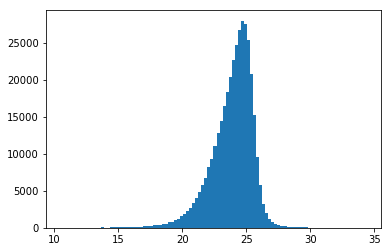

In [13]:
plt.hist(help_cat['help_m_vista_y'][help_cat['help_m_vista_y']<40], bins=100)

### 3.2.3 The LSST stack catalogues

These must be combined from the individual patch files. I think this can be done by id which should be consistent between patches

Boundaries are managed by the in inner regions flags. Shoudl we be doing this with the Butler or directly with the fits files?

In [14]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs='data/rerun/coaddForcedPhot')

In [15]:
ks_stack_files = glob.glob('./data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/8524/*/forcedSrc*.fits')
y_stack_files = glob.glob('./data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/*/forcedSrc*.fits')

In [16]:
y_stack_files

['./data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/3,5/forcedSrc-VISTA-Y-8524-3,5.fits']

In [17]:
full_cat = Table()
for f in y_stack_files:
    tract = 8524
    patch = str(f[-8:-5])
    print(patch)
    ySources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
    ksSources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})
    yCoaddPhotoCalib = butler.get('deepCoadd_forced_src',  {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
    ksCoaddPhotoCalib = butler.get('deepCoadd_forced_src',  {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})
    yCoaddCalexp = butler.get('deepCoadd_calexp',  {'filter': 'VISTA-Y', 'tract': tract, 'patch': patch})
    yCoaddPhotoCalib = yCoaddCalexp.getPhotoCalib()
    ksCoaddCalexp = butler.get('deepCoadd_calexp',  {'filter': 'VISTA-Ks', 'tract': tract, 'patch': patch})
    ksCoaddPhotoCalib = ksCoaddCalexp.getPhotoCalib()
    f_type = 'base_PsfFlux' #'base_PsfFlux' 'base_CircularApertureFlux_3_0'
    yMags = yCoaddPhotoCalib.instFluxToMagnitude(ySources, f_type)
    ksMags = ksCoaddPhotoCalib.instFluxToMagnitude(ksSources, f_type)
    yFlux = yCoaddPhotoCalib.instFluxToNanojansky(ySources, f_type)
    ksFlux = ksCoaddPhotoCalib.instFluxToNanojansky(ksSources, f_type)
    sn5 = (yFlux[:,0]/yFlux[:,1] > 5) & (ksFlux[:,0]/ksFlux[:,1] > 5)
    isDeblended = ySources['deblend_nChild'] == 0
    refTable = butler.get('deepCoadd_ref', {'filter': 'VISTA-Y^VISTA-Ks', 'tract': tract, 'patch': patch})
    #refTable
    inInnerRegions = refTable['detect_isPatchInner'] & refTable['detect_isTractInner']
    isSkyObject = refTable['merge_peak_sky']
    isPrimary = refTable['detect_isPrimary']
    isStellar = refTable['base_ClassificationExtendedness_value'] < 1.
    ySources.getSchema().extract('{}_*'.format(f_type))
    isGoodFlux = ~ySources['{}_flag'.format(f_type)]
    selected = isPrimary & isGoodFlux & inInnerRegions & isStellar  
    cat = Table()
    cat['f_vista_ks'] = ksFlux[:,0]
    cat['ferr_vista_ks'] = ksFlux[:,1]
    cat['f_vista_y'] = yFlux[:,0]
    cat['ferr_vista_y'] = yFlux[:,1]
    cat['m_vista_ks'] = ksMags[:,0]
    cat['merr_vista_ks'] = ksMags[:,1]
    cat['m_vista_y'] = yMags[:,0]
    cat['merr_vista_y'] = yMags[:,1]
    cat['ra'] = ySources['coord_ra']
    cat['dec'] = ySources['coord_dec']
    cat['flag'] = selected
    full_cat = vstack([full_cat,cat])

3,5
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/3,5/forcedSrc-VISTA-Y-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/8524/3,5/forcedSrc-VISTA-Ks-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Y/8524/3,5/forcedSrc-VISTA-Y-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/8524/3,5/forcedSrc-VISTA-Ks-8524-3,5.fits
DEBUG:  /Users/rs548/GitHub/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/merged/8524/3,5/ref-8524-3,5.fits


In [18]:
refTable.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="merge_footprint_HSC-G", doc="Detection footprint overlapped with a detection from filter HSC-G"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="merge_footprint_HSC-R", doc="Detection footprint overlapped with a detection from filter HSC-R"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="merge_footprint_HSC-I", doc="Detection footprint overlapped with a detection from filter HSC-I"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="merge_footprint_HSC-Z", doc="Detection footprint overlapped with a detection from filter HSC-Z"), Key['Flag'](offset=32, bit

In [19]:
full_cat[:10].show_in_notebook()

idx,f_vista_ks,ferr_vista_ks,f_vista_y,ferr_vista_y,m_vista_ks,merr_vista_ks,m_vista_y,merr_vista_y,ra,dec,flag
0,5923.621686428734,685.8286995877343,635.7819911541907,256.6712561761404,21.968531713975494,0.1257050312835754,24.39172944464358,0.43832206546976427,0.6280780421703175,-0.08931494200307842,False
1,5276.515432827781,676.9141815645976,1208.1808533617766,253.22767962039404,22.094131968229625,0.13928704346554488,23.694670127577492,0.22756399345821018,0.6279856398683025,-0.08931661122849316,False
2,10452.531714752744,664.5150032718263,5846.349933131951,249.7933617219708,21.351946265131208,0.06902519096295855,21.98278798378756,0.04638957633938571,0.6278433557341965,-0.08931748623812362,False
3,6479.311481798567,661.1054444020859,2912.4115479668667,247.8687313520242,21.871177853974185,0.11078123318603135,22.739368139003417,0.0924045421548441,0.6278098288999436,-0.08931750024011086,False
4,5648.462641720535,659.0368005153708,-82.64151460211683,246.35640126299876,22.020174348181293,0.12667873720229544,nan,3.2366065096090066,0.6277820261513538,-0.08931751177577356,False
5,7624.395823692514,657.9806681485878,150.04804261893656,245.93557663911884,21.694486413012743,0.09369836639644495,25.959424163965686,1.7795710955942854,0.6277689418133571,-0.08931588822809239,False
6,5775.999120691861,654.7679048545289,5061.341844745634,246.05639260164347,21.995932203882873,0.12307917732664655,22.139335823259827,0.0527829065995859,0.6277345979165802,-0.08931753129576431,False
7,5374.345884420357,650.5586818739107,-415.26783509169763,242.66317332784976,22.07418596623963,0.13142717819443286,nan,0.6344536479339071,0.6276667264411498,-0.0893175588819346,False
8,15809.03723894317,638.9271814025484,5584.60743814256,222.10417441776053,20.902736443851605,0.04388036808111067,22.03251837393603,0.04318057196755843,0.6274344912005075,-0.08931765017731096,False
9,8009.352400867584,711.3458912404702,589.5228090314394,212.3345843982708,21.641006493840468,0.09642901817406073,24.47374846775023,0.3910609433114886,0.6272365996303041,-0.08931609523404997,False


(array([   4.,    0.,    0.,    0.,    2.,    0.,    0.,    2.,    2.,
           0.,    0.,    2.,    2.,    8.,    2.,    6.,    2.,    4.,
           6.,    0.,    0.,    8.,    8.,    7.,    4.,   10.,   10.,
           8.,    5.,   14.,    6.,    6.,   19.,    9.,   10.,   26.,
          18.,   22.,   13.,   29.,   41.,   55.,   39.,   54.,   62.,
          63.,   69.,   92.,  134.,  106.,  181.,  140.,  170.,  174.,
         203.,  205.,  242.,  287.,  398.,  583.,  850., 1113., 1352.,
        1547., 1728., 1693., 1602., 1487., 1301., 1176., 1025.,  983.,
         896.,  913.,  885.,  905.,  944.,  863.,  859.,  852.,  781.,
         695.,  663.,  530.,  460.,  385.,  332.,  293.,  216.,  186.,
         164.,  134.,  130.,   80.,   87.,   57.,   50.,   49.,   43.,
          43.]),
 array([12.74951313, 12.92189448, 13.09427583, 13.26665718, 13.43903853,
        13.61141988, 13.78380123, 13.95618258, 14.12856393, 14.30094528,
        14.47332663, 14.64570798, 14.81808933, 14.990470

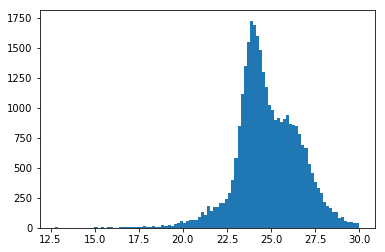

In [20]:
m = full_cat['m_vista_y'] < 30
plt.hist(full_cat['m_vista_y'][m], bins = 100)

(array([4.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        4.000e+00, 2.000e+00, 8.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        6.000e+00, 8.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 2.000e+00,
        1.400e+01, 9.000e+00, 9.000e+00, 1.000e+01, 8.000e+00, 8.000e+00,
        1.000e+00, 6.000e+00, 1.400e+01, 1.600e+01, 1.300e+01, 1.900e+01,
        3.100e+01, 2.400e+01, 2.800e+01, 4.100e+01, 2.500e+01, 3.600e+01,
        4.900e+01, 5.800e+01, 6.500e+01, 8.200e+01, 6.300e+01, 6.200e+01,
        1.030e+02, 1.110e+02, 1.200e+02, 1.060e+02, 1.280e+02, 1.280e+02,
        1.830e+02, 2.070e+02, 3.140e+02, 5.360e+02, 1.186e+03, 2.616e+03,
        4.861e+03, 7.262e+03, 8.910e+03, 7.797e+03, 3.296e+03, 8.650e+02,
        2.570e+02, 9.900e+01, 4.100e+01, 2.100e+01, 2.300e+01, 1.300e+01,
        8.000e+00, 1.200e+01, 3.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 1.000e+00, 2.000e+0

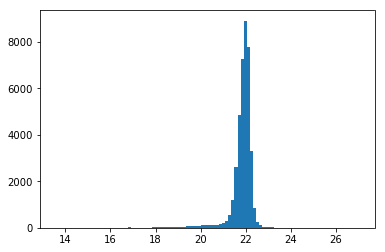

In [21]:
m = full_cat['m_vista_ks'] < 30
plt.hist(full_cat[m]['m_vista_ks'], bins = 100)

In [22]:
s5 = full_cat['f_vista_ks']/full_cat['ferr_vista_ks'] > 5
s5 &= full_cat['f_vista_y']/full_cat['ferr_vista_y'] > 5

(array([  2.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,
          2.,   0.,   0.,   0.,   2.,   2.,   0.,   8.,   0.,   4.,   4.,
          2.,   4.,   4.,   2.,   0.,   0.,   2.,   6.,   8.,   2.,   5.,
          4.,   8.,   6.,   8.,   6.,   2.,   7.,  10.,   6.,   2.,  14.,
          9.,   7.,   3.,  14.,  19.,   9.,  23.,  10.,  13.,  12.,  30.,
         32.,  47.,  19.,  43.,  38.,  47.,  43.,  43.,  57.,  62.,  74.,
        101.,  82., 130., 115., 102., 131., 133., 121., 157., 152., 158.,
        162., 217., 262., 351., 475., 649., 731., 859., 707., 524., 366.,
         16.,   3.,   5.,   2.,   0.,   2.,   3.,   2.,   1.,   0.,   1.,
          1.]),
 array([12.74951313, 12.87604787, 13.0025826 , 13.12911734, 13.25565207,
        13.38218681, 13.50872154, 13.63525628, 13.76179101, 13.88832574,
        14.01486048, 14.14139521, 14.26792995, 14.39446468, 14.52099942,
        14.64753415, 14.77406889, 14.90060362, 15.02713836, 15.15367309,
        15.28020782, 15.40

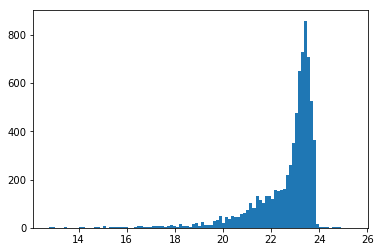

In [23]:
plt.hist(full_cat['m_vista_y'][s5], bins = 100)

(array([  2.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,
          2.,   0.,   0.,   0.,   2.,   2.,   0.,   8.,   0.,   4.,   4.,
          2.,   4.,   4.,   2.,   0.,   0.,   2.,   6.,   8.,   2.,   5.,
          4.,   8.,   6.,   8.,   6.,   2.,   7.,  10.,   6.,   2.,  14.,
          9.,   7.,   3.,  14.,  19.,   9.,  23.,  10.,  13.,  12.,  30.,
         32.,  47.,  19.,  43.,  38.,  47.,  43.,  43.,  57.,  62.,  74.,
        101.,  82., 130., 115., 102., 131., 133., 121., 157., 152., 158.,
        162., 217., 262., 351., 475., 649., 731., 859., 707., 524., 366.,
         16.,   3.,   5.,   2.,   0.,   2.,   3.,   2.,   1.,   0.,   1.,
          1.]),
 array([12.74951313, 12.87604787, 13.0025826 , 13.12911734, 13.25565207,
        13.38218681, 13.50872154, 13.63525628, 13.76179101, 13.88832574,
        14.01486048, 14.14139521, 14.26792995, 14.39446468, 14.52099942,
        14.64753415, 14.77406889, 14.90060362, 15.02713836, 15.15367309,
        15.28020782, 15.40

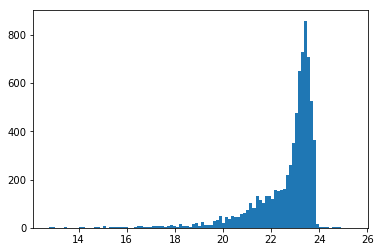

In [24]:
plt.hist(full_cat['m_vista_y'][s5], bins = 100)

### Oxford Ks selected 2 arcsec catalogue
We found this to be the best catalogue for comparisons in dmu2/2_Colour_terms.ipynb

In [25]:
imported_columns = OrderedDict({
        'ID_se':              'id', 
        'RA':     'ra', 
        'DEC':     'dec', 
    
        #'J_CLASS_STAR':    'vista_stellarity', 
     
        #HSC GRIZY?
        'flux_Y':    'f_ap_vista_y', 
        'err_Y': 'ferr_ap_vista_y', #Flux error? ~E-30

    
        'flux_J':    'f_ap_vista_j', 
        'err_J': 'ferr_ap_vista_j', 

    
        'flux_H':    'f_ap_vista_h', 
        'err_H': 'ferr_ap_vista_h', 

  
        'flux_Ks':    'f_ap_vista_ks', 
        'err_Ks': 'ferr_ap_vista_ks', 


})


oxford_ks_cat = Table.read(OXFORD_VISTA_Ks_CAT
                      )[list(imported_columns)]
for column in imported_columns:
    oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]
    

    
oxford_ks_cat['oxford_ks_ra'].unit = u.deg
oxford_ks_cat['oxford_ks_dec'].unit = u.deg
oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)

print(len(oxford_ks_cat))
mask = oxford_ks_cat['oxford_ks_ra'] <  np.max(ks_tile_cat['ks_tile_RA'])
mask &= oxford_ks_cat['oxford_ks_ra'] >  np.min(ks_tile_cat['ks_tile_RA'])
mask &= oxford_ks_cat['oxford_ks_dec'] <  np.max(ks_tile_cat['ks_tile_DEC'])
mask &= oxford_ks_cat['oxford_ks_dec'] >  np.min(ks_tile_cat['ks_tile_DEC'])
oxford_ks_cat = oxford_ks_cat[mask]
print(len(oxford_ks_cat))

1674689
610117


In [26]:
#convert units and fluxes to mags
#From Rebecca units are in cgs (ergs/s/cm2)
#I presume she means cgs flux densities (ergs/s/cm2/Hz) - check for large offset
for col in oxford_ks_cat.colnames:
    if col.startswith('oxford_ks_f_'):
        err_col = col.replace('_f_', '_ferr_')
        oxford_ks_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[col].convert_unit_to(u.uJy)
        oxford_ks_cat[err_col].convert_unit_to(u.uJy)
        m,merr = flux_to_mag(oxford_ks_cat[col]*1e-6,oxford_ks_cat[err_col]*1e-6) # expects Jansky
        oxford_ks_cat[col.replace('_f_', '_m_')] = m
        oxford_ks_cat[err_col.replace('_ferr_', '_merr_')] = merr

### 3.2.4 Merge the three catalogues

we merge by positional cross match then plot some key statistics

In [27]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue

In [28]:
merge = merge_catalogues(full_cat, y_tile_cat, 'y_tile_RA', 'y_tile_DEC')
merge = merge_catalogues(merge, ks_tile_cat, 'ks_tile_RA', 'ks_tile_DEC')
merge = merge_catalogues(merge, help_cat, 'help_ra', 'help_dec')
merge = merge_catalogues(merge, oxford_ks_cat, 'oxford_ks_ra', 'oxford_ks_dec')

In [29]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (table[col].dtype == 'float64') or (table[col].dtype == 'float32'):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table
merge = clean_table(merge)

In [30]:
merge_filename = './data/sxds_merge_test.fits'
merge.write(merge_filename, overwrite=True)

In [31]:
#merge = Table.read(merge_filename)

In [32]:
merge[:5].show_in_notebook()

idx,f_vista_ks,ferr_vista_ks,f_vista_y,ferr_vista_y,m_vista_ks,merr_vista_ks,m_vista_y,merr_vista_y,ra,dec,flag,flag_merged,y_tile_Sequence_number,y_tile_Isophotal_flux,y_tile_X_coordinate,y_tile_X_coordinate_err,y_tile_Y_coordinate,y_tile_Y_coordinate_err,y_tile_Gaussian_sigma,y_tile_Ellipticity,y_tile_Position_angle,y_tile_Areal_1_profile,y_tile_Areal_2_profile,y_tile_Areal_3_profile,y_tile_Areal_4_profile,y_tile_Areal_5_profile,y_tile_Areal_6_profile,y_tile_Areal_7_profile,y_tile_Areal_8_profile,y_tile_Peak_height,y_tile_Peak_height_err,y_tile_Aper_flux_1,y_tile_Aper_flux_1_err,y_tile_Aper_flux_2,y_tile_Aper_flux_2_err,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_Aper_flux_4,y_tile_Aper_flux_4_err,y_tile_Aper_flux_5,y_tile_Aper_flux_5_err,y_tile_Aper_flux_6,y_tile_Aper_flux_6_err,y_tile_Aper_flux_7,y_tile_Aper_flux_7_err,y_tile_Aper_flux_8,y_tile_Aper_flux_8_err,y_tile_Aper_flux_9,y_tile_Aper_flux_9_err,y_tile_Aper_flux_10,y_tile_Aper_flux_10_err,y_tile_Aper_flux_11,y_tile_Aper_flux_11_err,y_tile_Aper_flux_12,y_tile_Aper_flux_12_err,y_tile_Aper_flux_13,y_tile_Aper_flux_13_err,y_tile_Petr_radius,y_tile_Kron_radius,y_tile_Half_radius,y_tile_Petr_flux,y_tile_Petr_flux_err,y_tile_Kron_flux,y_tile_Kron_flux_err,y_tile_Half_flux,y_tile_Half_flux_err,y_tile_Error_bit_flag,y_tile_Sky_level,y_tile_Sky_rms,y_tile_Av_conf,y_tile_Classification,y_tile_Statistic,y_tile_MJDoff,y_tile_Blank64,y_tile_Blank65,y_tile_Blank66,y_tile_Blank67,y_tile_Blank68,y_tile_Blank69,y_tile_Blank70,y_tile_Blank71,y_tile_Blank72,y_tile_Blank73,y_tile_Blank74,y_tile_Blank75,y_tile_Blank76,y_tile_Blank77,y_tile_Blank78,y_tile_Blank79,y_tile_Blank80,y_tile_m_vista_y,y_tile_merr_vista_y,ks_tile_Sequence_number,ks_tile_Isophotal_flux,ks_tile_X_coordinate,ks_tile_X_coordinate_err,ks_tile_Y_coordinate,ks_tile_Y_coordinate_err,ks_tile_Gaussian_sigma,ks_tile_Ellipticity,ks_tile_Position_angle,ks_tile_Areal_1_profile,ks_tile_Areal_2_profile,ks_tile_Areal_3_profile,ks_tile_Areal_4_profile,ks_tile_Areal_5_profile,ks_tile_Areal_6_profile,ks_tile_Areal_7_profile,ks_tile_Areal_8_profile,ks_tile_Peak_height,ks_tile_Peak_height_err,ks_tile_Aper_flux_1,ks_tile_Aper_flux_1_err,ks_tile_Aper_flux_2,ks_tile_Aper_flux_2_err,ks_tile_Aper_flux_3,ks_tile_Aper_flux_3_err,ks_tile_Aper_flux_4,ks_tile_Aper_flux_4_err,ks_tile_Aper_flux_5,ks_tile_Aper_flux_5_err,ks_tile_Aper_flux_6,ks_tile_Aper_flux_6_err,ks_tile_Aper_flux_7,ks_tile_Aper_flux_7_err,ks_tile_Aper_flux_8,ks_tile_Aper_flux_8_err,ks_tile_Aper_flux_9,ks_tile_Aper_flux_9_err,ks_tile_Aper_flux_10,ks_tile_Aper_flux_10_err,ks_tile_Aper_flux_11,ks_tile_Aper_flux_11_err,ks_tile_Aper_flux_12,ks_tile_Aper_flux_12_err,ks_tile_Aper_flux_13,ks_tile_Aper_flux_13_err,ks_tile_Petr_radius,ks_tile_Kron_radius,ks_tile_Half_radius,ks_tile_Petr_flux,ks_tile_Petr_flux_err,ks_tile_Kron_flux,ks_tile_Kron_flux_err,ks_tile_Half_flux,ks_tile_Half_flux_err,ks_tile_Error_bit_flag,ks_tile_Sky_level,ks_tile_Sky_rms,ks_tile_Av_conf,ks_tile_Classification,ks_tile_Statistic,ks_tile_MJDoff,ks_tile_Blank64,ks_tile_Blank65,ks_tile_Blank66,ks_tile_Blank67,ks_tile_Blank68,ks_tile_Blank69,ks_tile_Blank70,ks_tile_Blank71,ks_tile_Blank72,ks_tile_Blank73,ks_tile_Blank74,ks_tile_Blank75,ks_tile_Blank76,ks_tile_Blank77,ks_tile_Blank78,ks_tile_Blank79,ks_tile_Blank80,ks_tile_m_vista_ks,ks_tile_merr_vista_ks,help_video_id,help_vista_stellarity,help_m_ap_vista_y,help_merr_ap_vista_y,help_m_vista_y,help_merr_vista_y,help_f_ap_vista_y,help_ferr_ap_vista_y,help_f_vista_y,help_ferr_vista_y,help_m_ap_vista_ks,help_merr_ap_vista_ks,help_m_vista_ks,help_merr_vista_ks,oxford_ks_id,oxford_ks_f_ap_vista_y,oxford_ks_ferr_ap_vista_y,oxford_ks_f_ap_vista_j,oxford_ks_ferr_ap_vista_j,oxford_ks_f_ap_vista_h,oxford_ks_ferr_ap_vista_h,oxford_ks_f_ap_vista_ks,oxford_ks_ferr_ap_vista_ks,oxford_ks_m_ap_vista_y,oxford_ks_merr_ap_vista_y,oxford_ks_m_ap_vista_j,oxford_ks_merr_ap_vista_j,oxford_ks_m_ap_vista_h,oxford_ks_merr_ap_vista_h,oxford_ks_m_ap_vista_ks,oxford_ks_merr_ap_vista_ks
,,,,,,,

## 3.3 Diagnostic plots


The selection has a large effect on the plots. We probably want to look at objects detected in Y and Ks and that are stars in HELP and the tile. 


In [33]:
mask = merge['flag']
mask &= merge['f_vista_ks']/merge['ferr_vista_ks'] > 5
mask &= merge['f_vista_y']/merge['ferr_vista_y'] > 5
mask &= np.isclose(merge['ks_tile_Classification'], -1.0)
mask &= merge['help_vista_stellarity'] > 0.9


### 3.3.0 Err mag

Text(0, 0.5, 'LSST stack Ks AB mag error [mag]')

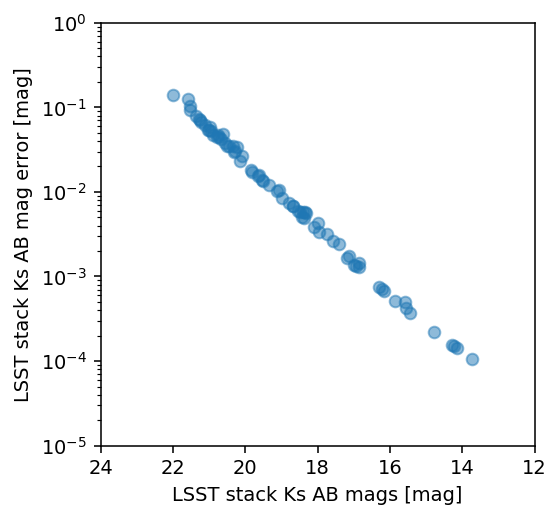

In [34]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_ks'], merge[mask]['merr_vista_ks'] , alpha=0.5)
plt.xlabel('LSST stack Ks AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('LSST stack Ks AB mag error [mag]')

Text(0, 0.5, 'VISTA pipe Ks AB mag error [mag]')

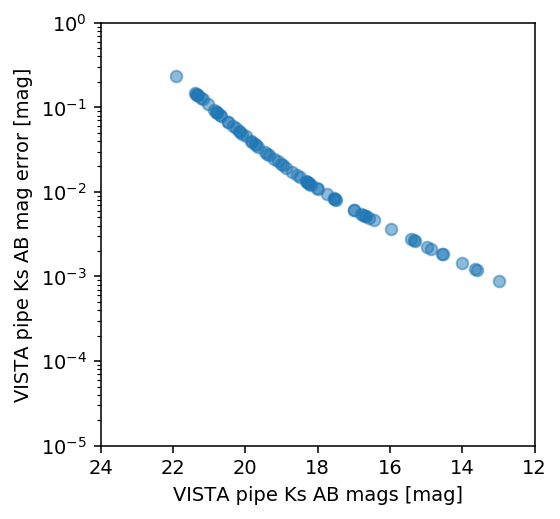

In [35]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['ks_tile_m_vista_ks'], merge[mask]['ks_tile_merr_vista_ks'] , alpha=0.5)
plt.xlabel('VISTA pipe Ks AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('VISTA pipe Ks AB mag error [mag]')

Text(0, 0.5, 'HELP Ks AB mag error [mag]')

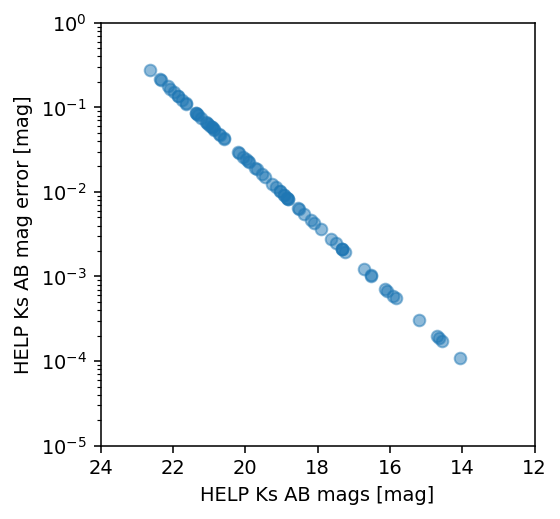

In [36]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['help_m_vista_ks'], merge[mask]['help_merr_vista_ks'] , alpha=0.5)
plt.xlabel('HELP Ks AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('HELP Ks AB mag error [mag]')

Text(0, 0.5, 'LSST stack Y AB mag error [mag]')

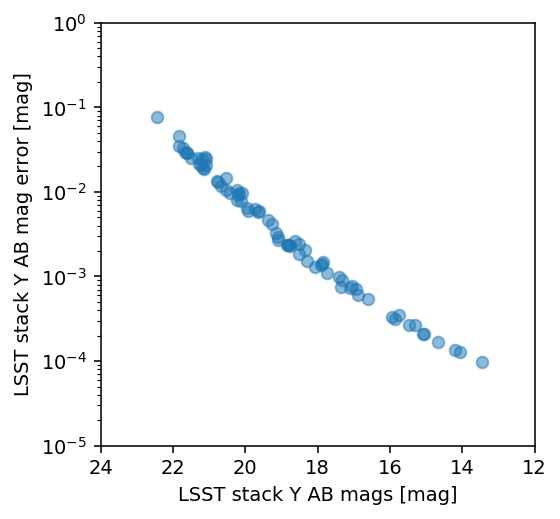

In [37]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_y'], merge[mask]['merr_vista_y'] , alpha=0.5)
plt.xlabel('LSST stack Y AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('LSST stack Y AB mag error [mag]')

Text(0, 0.5, 'HELP Y AB mag error [mag]')

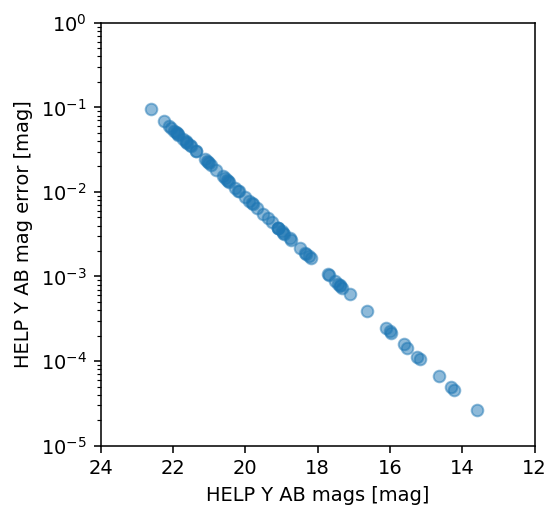

In [38]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['help_m_vista_y'], merge[mask]['help_merr_vista_y'] , alpha=0.5)
plt.xlabel('HELP Y AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('HELP Y AB mag error [mag]')

Text(0, 0.5, 'VISTA pipe Y AB mag error [mag]')

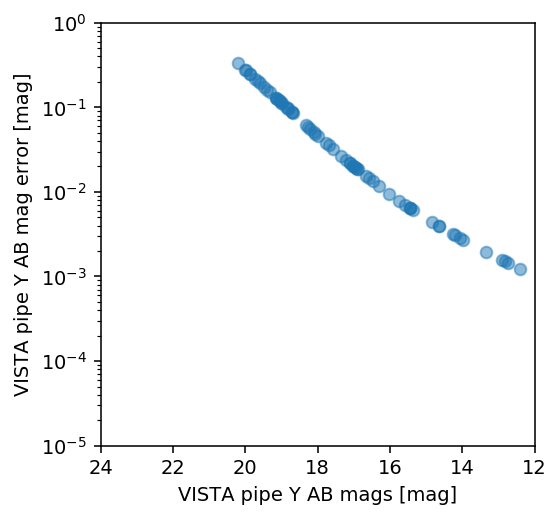

In [39]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['y_tile_m_vista_y'], merge[mask]['y_tile_merr_vista_y'] , alpha=0.5)
plt.xlabel('VISTA pipe Y AB mags [mag]')
#plt.plot([12,26],[12,26], c='r')
plt.xlim([24,12])
plt.ylim([1.e-5, 1])
plt.yscale('log')
plt.ylabel('VISTA pipe Y AB mag error [mag]')

### 3.3.1 Mag-mag

Text(0, 0.5, 'HELP Ks AB mags [mag]')

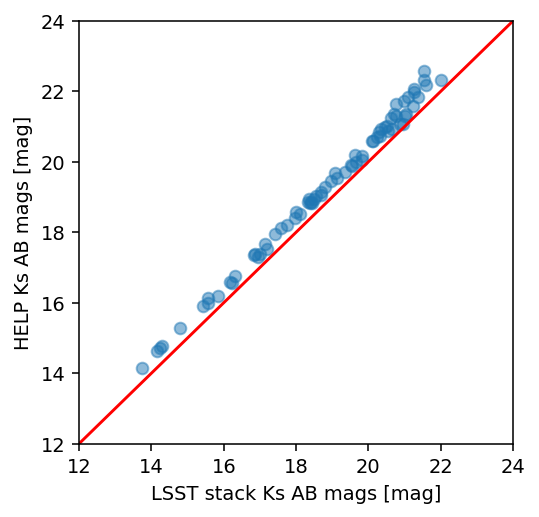

In [40]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_ks'], merge[mask]['help_m_ap_vista_ks'], alpha=0.5)
plt.xlabel('LSST stack Ks AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('HELP Ks AB mags [mag]')

Text(0, 0.5, 'VISTA pipe Ks AB?? mags [mag]')

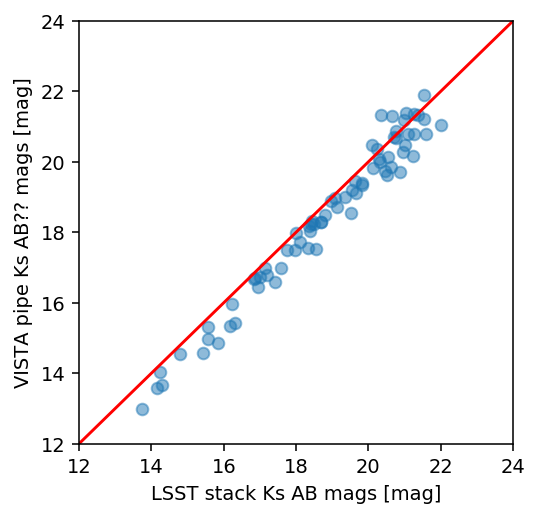

In [41]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_ks'], merge[mask]['ks_tile_m_vista_ks'], alpha=0.5)
plt.xlabel('LSST stack Ks AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('VISTA pipe Ks AB?? mags [mag]')

Text(0, 0.5, 'HELP Y AB mags [mag]')

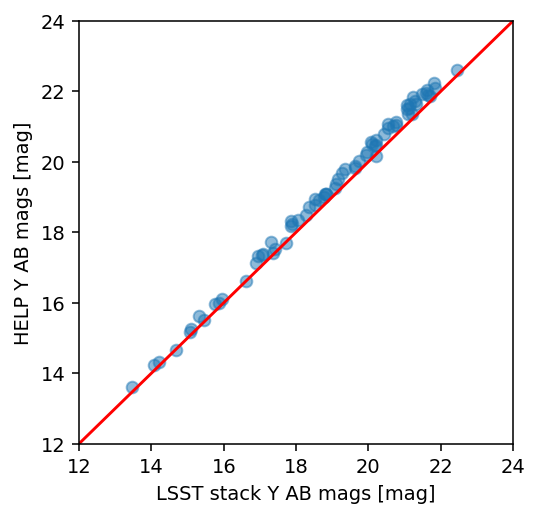

In [42]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_y'], merge[mask]['help_m_vista_y'], alpha=0.5)
plt.xlabel('LSST stack Y AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('HELP Y AB mags [mag]')

Text(0, 0.5, 'VISTA pipe Y AB mags [mag]')

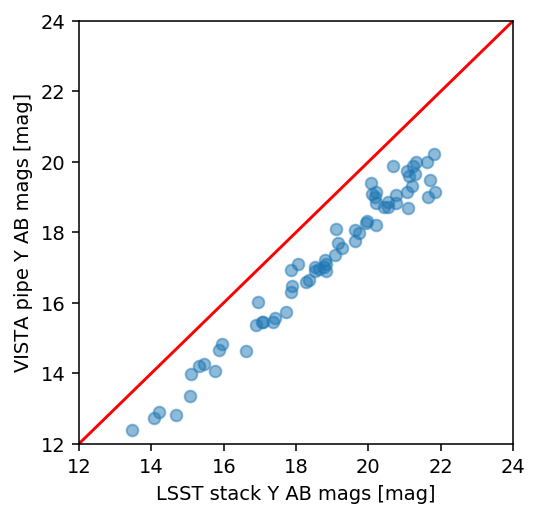

In [43]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['m_vista_y'], merge[mask]['y_tile_m_vista_y'], alpha=0.5)
plt.xlabel('LSST stack Y AB mags [mag]')
plt.plot([12,26],[12,26], c='r')
plt.xlim([12,24])
plt.ylim([12,24])
plt.ylabel('VISTA pipe Y AB mags [mag]')

Is this a vega AB issue or zero point issue??

### 3.3.2 Mag diff - mag



Mean offset = -0.478494294308162
Median offset = -0.47111684135320253


Text(0, 0.5, 'LSST stack - HELP Ks AB mags [mag]')

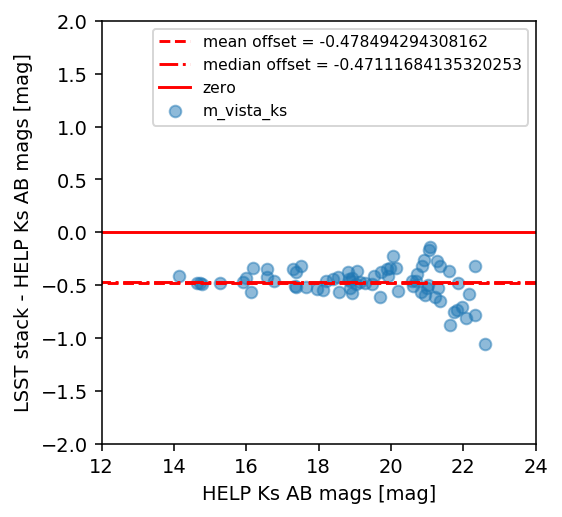

In [44]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = mask & (merge['help_m_ap_vista_ks'] < 30)
mean_offset = np.mean(merge[m]['m_vista_ks'] - merge[m]['help_m_ap_vista_ks'])
median_offset = np.median(merge[m]['m_vista_ks'] - merge[m]['help_m_ap_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[mask]['help_m_ap_vista_ks'],   merge[mask]['m_vista_ks'] - merge[mask]['help_m_ap_vista_ks'], alpha=0.5)
plt.xlabel('HELP Ks AB mags [mag]')
plt.legend( prop={'size': 8})

plt.xlim([12,24])
plt.ylim([-2,2])
plt.ylabel('LSST stack - HELP Ks AB mags [mag]')

Mean offset = 0.3598625847142244
Median offset = 0.3426302323825716


Text(0, 0.5, 'LSST stack - VISTA pipe Ks AB mags [mag]')

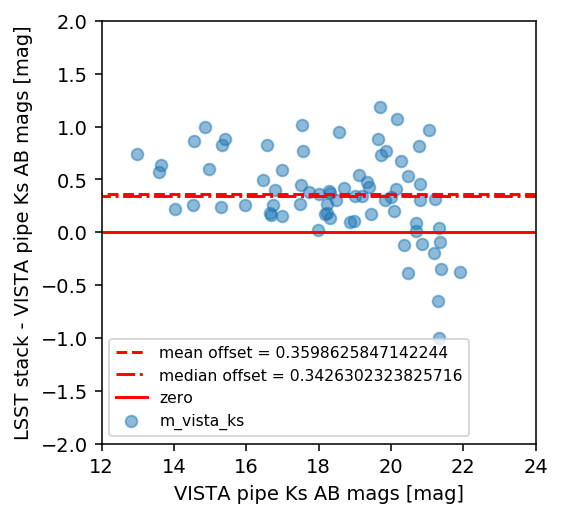

In [45]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = mask & (merge['ks_tile_m_vista_ks'] < 30)
mean_offset = np.mean(merge[m]['m_vista_ks'] - merge[m]['ks_tile_m_vista_ks'])
median_offset = np.median(merge[m]['m_vista_ks'] - merge[m]['ks_tile_m_vista_ks'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[mask]['ks_tile_m_vista_ks'],   merge[mask]['m_vista_ks'] - merge[mask]['ks_tile_m_vista_ks'], alpha=0.5)
plt.xlabel('VISTA pipe Ks AB mags [mag]')
plt.legend( prop={'size': 8})
plt.xlim([12,24])
plt.ylim([-2,2])
plt.ylabel('LSST stack - VISTA pipe Ks AB mags [mag]')

Mean offset = -0.31276382907138955
Median offset = -0.30971282612309103


Text(0, 0.5, 'LSST stack Y - HELP Y  [mag]')

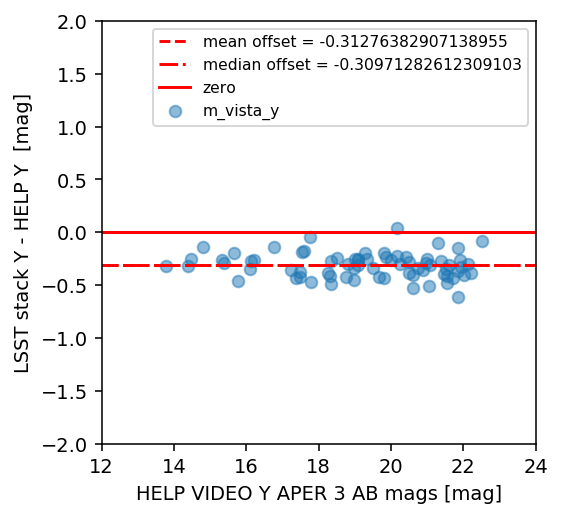

In [46]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = mask & (merge['help_m_ap_vista_y'] < 30)
mean_offset = np.mean(merge[m]['m_vista_y'] - merge[m]['help_m_ap_vista_y'])
median_offset = np.median(merge[m]['m_vista_y'] - merge[m]['help_m_ap_vista_y'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[mask]['help_m_ap_vista_y'],   merge[mask]['m_vista_y'] - merge[mask]['help_m_ap_vista_y'], alpha=0.5)
plt.xlabel('HELP VIDEO Y APER 3 AB mags [mag]')
plt.plot([0,26],[0,0], c='r')
plt.legend( prop={'size': 8})
plt.xlim([12,24])
plt.ylim([-2,2])
plt.ylabel('LSST stack Y - HELP Y  [mag]')

Mean offset = 1.571932299243163
Median offset = 1.6252607159385448


Text(0, 0.5, 'LSST stack - VISTA pipe Y AB mags [mag]')

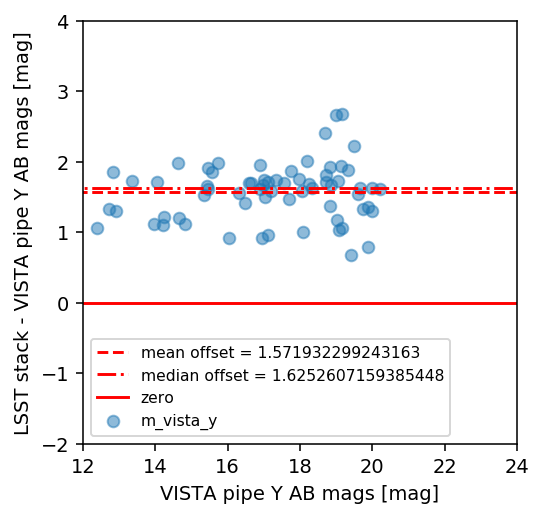

In [47]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = mask & (merge['y_tile_m_vista_y'] < 30)
mean_offset = np.mean(merge[m]['m_vista_y'] - merge[m]['y_tile_m_vista_y'])
median_offset = np.median(merge[m]['m_vista_y'] - merge[m]['y_tile_m_vista_y'])
print("Mean offset = {}".format(mean_offset))
print("Median offset = {}".format(median_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r', label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.plot([0,26],[0,0], c='r', label='zero')
plt.scatter(merge[mask]['y_tile_m_vista_y'],   merge[mask]['m_vista_y'] - merge[mask]['y_tile_m_vista_y'], alpha=0.5)
plt.xlabel('VISTA pipe Y AB mags [mag]')
plt.legend( prop={'size': 8})
plt.xlim([12,24])
plt.ylim([-2,4])
plt.ylabel('LSST stack - VISTA pipe Y AB mags [mag]')

Mean offset = -0.4141894777857034


Text(0, 0.5, 'LSST stack Ks - Oxford Ks [mag]')

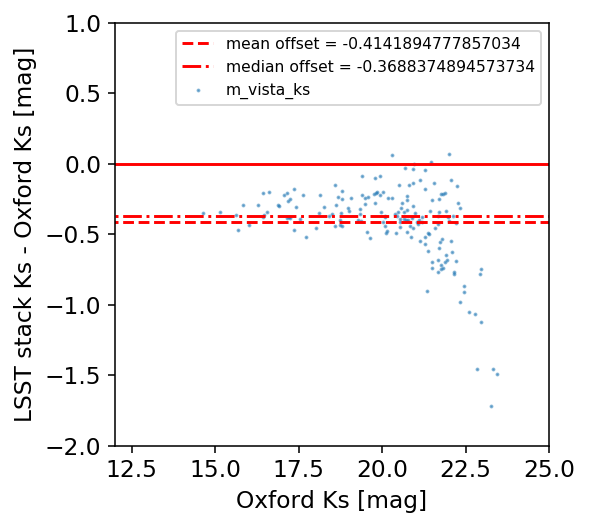

In [71]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    np.full(len(merge),True)
    #(merge['ks'] > 0) 
     #(merge['help_m_ap_vista_ks']<30) 
   #&(merge['ks_tile_Classification'] == -1) 
    & (merge['help_vista_stellarity']>0.9)
)

x_band, x_name = 'oxford_ks_m_ap_vista_ks', 'Oxford Ks'
y_band, y_name = 'm_vista_ks', 'LSST stack Ks'

mean_offset = np.nanmean((merge[m][y_band] ) - merge[m][x_band])
median_offset = np.nanmedian((merge[m][y_band] ) - merge[m][x_band])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m][x_band],   (merge[m][y_band] ) - merge[m][x_band], 
            s=1,alpha=0.5)
plt.xlabel(x_name + ' [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,25])
plt.ylim([-2,1])
plt.ylabel('{} - {} [mag]'.format(y_name,x_name))

Mean offset = -0.10941687034769335


Text(0, 0.5, 'LSST stack Y - Oxford Y [mag]')

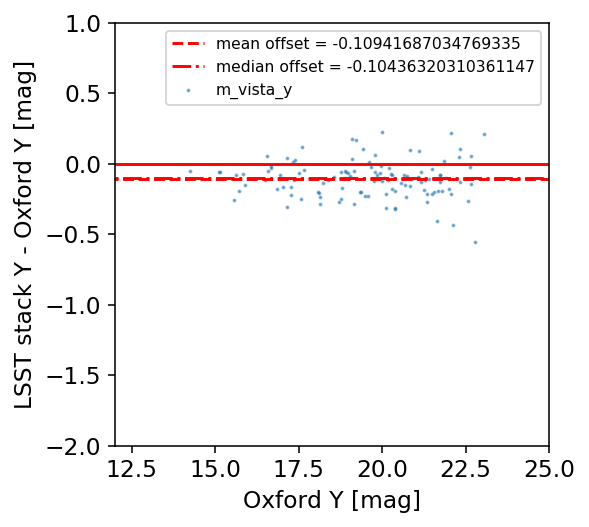

In [66]:
plt.figure(1, figsize=(4, 4), dpi=140)
m = (
    #(merge['ks'] > 0) 
     #(merge['help_m_ap_vista_ks']<30) 
   (merge['ks_tile_Classification'] == -1) 
   # & (merge['help_vista_stellarity']>0.9)
)

x_band, x_name = 'oxford_ks_m_ap_vista_y', 'Oxford Y'
y_band, y_name = 'm_vista_y', 'LSST stack Y'

mean_offset = np.nanmean((merge[m][y_band] ) - merge[m][x_band])
median_offset = np.nanmedian((merge[m][y_band] ) - merge[m][x_band])
print("Mean offset = {}".format(mean_offset))
plt.plot([0,26],[mean_offset,mean_offset], linestyle='--', c='r',  label = 'mean offset = {}'.format(mean_offset))
plt.plot([0,26],[median_offset,median_offset], linestyle='dashdot', c='r',
         label = 'median offset = {}'.format(median_offset))
plt.scatter(merge[m][x_band],   (merge[m][y_band] ) - merge[m][x_band], 
            s=1,alpha=0.5)
plt.xlabel(x_name + ' [mag]')
plt.plot([0,26],[0,0], c='r')

plt.legend( prop={'size': 8})
plt.xlim([12,25])
plt.ylim([-2,1])
plt.ylabel('{} - {} [mag]'.format(y_name,x_name))

### 3.3.3 Colour mag

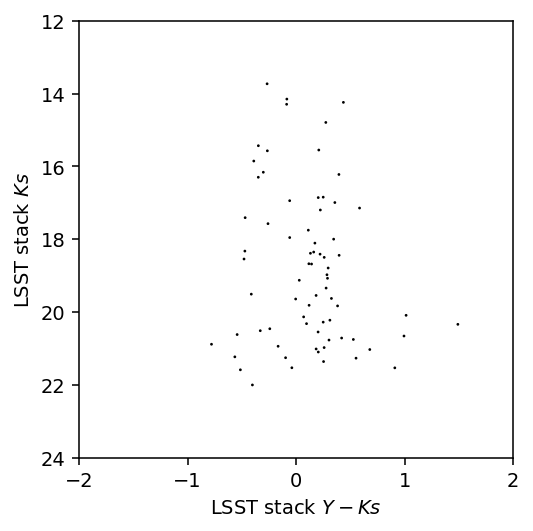

In [48]:
import matplotlib.pyplot as plt

#plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge['m_vista_y'][mask] - merge['m_vista_ks'][mask] ,
            merge['m_vista_ks'][mask] ,
            edgecolors='None', s=2, c='k')
plt.xlim(-2, 2)
plt.ylim(24, 12)
plt.xlabel('LSST stack $Y-Ks$')
plt.ylabel('LSST stack $Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

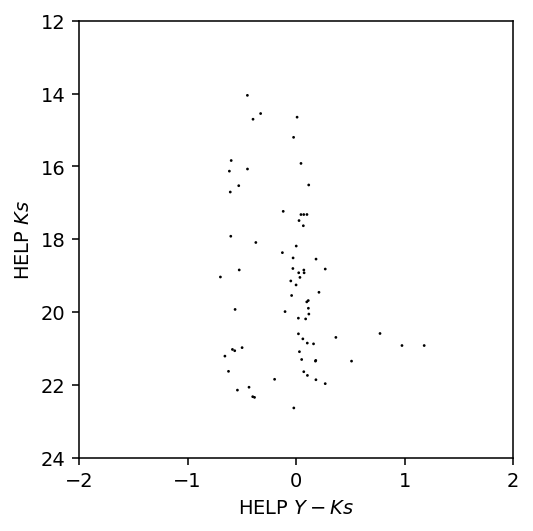

In [49]:
import matplotlib.pyplot as plt

#plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge['help_m_vista_y'][mask] - merge['help_m_vista_ks'][mask] ,
            merge['help_m_vista_ks'][mask] ,
            edgecolors='None', s=2, c='k')
plt.xlim(-2, 2)
plt.ylim(24, 12)
plt.xlabel('HELP $Y-Ks$')
plt.ylabel('HELP $Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [50]:
merge[merge['y_tile_m_vista_y'] < 1.e19][:10]

f_vista_ks,ferr_vista_ks,f_vista_y,ferr_vista_y,m_vista_ks,merr_vista_ks,m_vista_y,merr_vista_y,ra,dec,flag,flag_merged,y_tile_Sequence_number,y_tile_Isophotal_flux,y_tile_X_coordinate,y_tile_X_coordinate_err,y_tile_Y_coordinate,y_tile_Y_coordinate_err,y_tile_Gaussian_sigma,y_tile_Ellipticity,y_tile_Position_angle,y_tile_Areal_1_profile,y_tile_Areal_2_profile,y_tile_Areal_3_profile,y_tile_Areal_4_profile,y_tile_Areal_5_profile,y_tile_Areal_6_profile,y_tile_Areal_7_profile,y_tile_Areal_8_profile,y_tile_Peak_height,y_tile_Peak_height_err,y_tile_Aper_flux_1,y_tile_Aper_flux_1_err,y_tile_Aper_flux_2,y_tile_Aper_flux_2_err,y_tile_Aper_flux_3,y_tile_Aper_flux_3_err,y_tile_Aper_flux_4,y_tile_Aper_flux_4_err,y_tile_Aper_flux_5,y_tile_Aper_flux_5_err,y_tile_Aper_flux_6,y_tile_Aper_flux_6_err,y_tile_Aper_flux_7,y_tile_Aper_flux_7_err,y_tile_Aper_flux_8,y_tile_Aper_flux_8_err,y_tile_Aper_flux_9,y_tile_Aper_flux_9_err,y_tile_Aper_flux_10,y_tile_Aper_flux_10_err,y_tile_Aper_flux_11,y_tile_Aper_flux_11_err,y_tile_Aper_flux_12,y_tile_Aper_flux_12_err,y_tile_Aper_flux_13,y_tile_Aper_flux_13_err,y_tile_Petr_radius,y_tile_Kron_radius,y_tile_Half_radius,y_tile_Petr_flux,y_tile_Petr_flux_err,y_tile_Kron_flux,y_tile_Kron_flux_err,y_tile_Half_flux,y_tile_Half_flux_err,y_tile_Error_bit_flag,y_tile_Sky_level,y_tile_Sky_rms,y_tile_Av_conf,y_tile_Classification,y_tile_Statistic,y_tile_MJDoff,y_tile_Blank64,y_tile_Blank65,y_tile_Blank66,y_tile_Blank67,y_tile_Blank68,y_tile_Blank69,y_tile_Blank70,y_tile_Blank71,y_tile_Blank72,y_tile_Blank73,y_tile_Blank74,y_tile_Blank75,y_tile_Blank76,y_tile_Blank77,y_tile_Blank78,y_tile_Blank79,y_tile_Blank80,y_tile_m_vista_y,y_tile_merr_vista_y,ks_tile_Sequence_number,ks_tile_Isophotal_flux,ks_tile_X_coordinate,ks_tile_X_coordinate_err,ks_tile_Y_coordinate,ks_tile_Y_coordinate_err,ks_tile_Gaussian_sigma,ks_tile_Ellipticity,ks_tile_Position_angle,ks_tile_Areal_1_profile,ks_tile_Areal_2_profile,ks_tile_Areal_3_profile,ks_tile_Areal_4_profile,ks_tile_Areal_5_profile,ks_tile_Areal_6_profile,ks_tile_Areal_7_profile,ks_tile_Areal_8_profile,ks_tile_Peak_height,ks_tile_Peak_height_err,ks_tile_Aper_flux_1,ks_tile_Aper_flux_1_err,ks_tile_Aper_flux_2,ks_tile_Aper_flux_2_err,ks_tile_Aper_flux_3,ks_tile_Aper_flux_3_err,ks_tile_Aper_flux_4,ks_tile_Aper_flux_4_err,ks_tile_Aper_flux_5,ks_tile_Aper_flux_5_err,ks_tile_Aper_flux_6,ks_tile_Aper_flux_6_err,ks_tile_Aper_flux_7,ks_tile_Aper_flux_7_err,ks_tile_Aper_flux_8,ks_tile_Aper_flux_8_err,ks_tile_Aper_flux_9,ks_tile_Aper_flux_9_err,ks_tile_Aper_flux_10,ks_tile_Aper_flux_10_err,ks_tile_Aper_flux_11,ks_tile_Aper_flux_11_err,ks_tile_Aper_flux_12,ks_tile_Aper_flux_12_err,ks_tile_Aper_flux_13,ks_tile_Aper_flux_13_err,ks_tile_Petr_radius,ks_tile_Kron_radius,ks_tile_Half_radius,ks_tile_Petr_flux,ks_tile_Petr_flux_err,ks_tile_Kron_flux,ks_tile_Kron_flux_err,ks_tile_Half_flux,ks_tile_Half_flux_err,ks_tile_Error_bit_flag,ks_tile_Sky_level,ks_tile_Sky_rms,ks_tile_Av_conf,ks_tile_Classification,ks_tile_Statistic,ks_tile_MJDoff,ks_tile_Blank64,ks_tile_Blank65,ks_tile_Blank66,ks_tile_Blank67,ks_tile_Blank68,ks_tile_Blank69,ks_tile_Blank70,ks_tile_Blank71,ks_tile_Blank72,ks_tile_Blank73,ks_tile_Blank74,ks_tile_Blank75,ks_tile_Blank76,ks_tile_Blank77,ks_tile_Blank78,ks_tile_Blank79,ks_tile_Blank80,ks_tile_m_vista_ks,ks_tile_merr_vista_ks,help_video_id,help_vista_stellarity,help_m_ap_vista_y,help_merr_ap_vista_y,help_m_vista_y,help_merr_vista_y,help_f_ap_vista_y,help_ferr_ap_vista_y,help_f_vista_y,help_ferr_vista_y,help_m_ap_vista_ks,help_merr_ap_vista_ks,help_m_vista_ks,help_merr_vista_ks,oxford_ks_id,oxford_ks_f_ap_vista_y,oxford_ks_ferr_ap_vista_y,oxford_ks_f_ap_vista_j,oxford_ks_ferr_ap_vista_j,oxford_ks_f_ap_vista_h,oxford_ks_ferr_ap_vista_h,oxford_ks_f_ap_vista_ks,oxford_ks_ferr_ap_vista_ks,oxford_ks_m_ap_vista_y,oxford_ks_merr_ap_vista_y,oxford_ks_m_ap_vista_j,oxford_ks_merr_ap_vista_j,oxford_ks_m_ap_vista_h,oxford_ks_merr_ap_vista_h,oxford_ks_m_ap_vista_ks,oxford_ks_merr_ap_vista_ks
,,,,,,,,rad

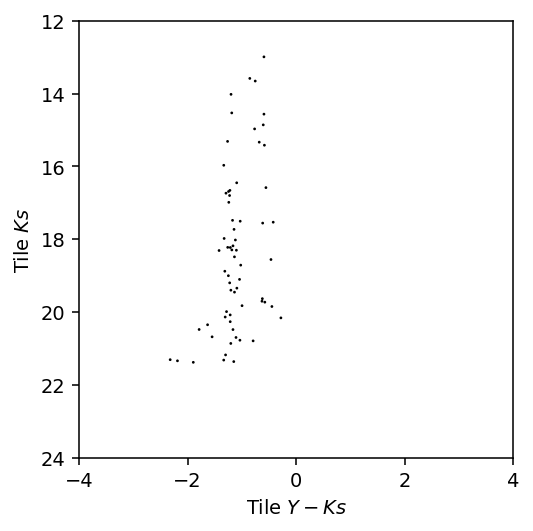

In [51]:
import matplotlib.pyplot as plt

#plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge['y_tile_m_vista_y'][mask] - merge['ks_tile_m_vista_ks'][mask] ,
            merge['ks_tile_m_vista_ks'][mask] ,
            edgecolors='None', s=2, c='k')
plt.xlim(-4, 4)
plt.ylim(24, 12)
plt.xlabel('Tile $Y-Ks$')
plt.ylabel('Tile $Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

### mag error - mag error

Text(0, 0.5, 'HELP Ks AB mag errors [mag]')

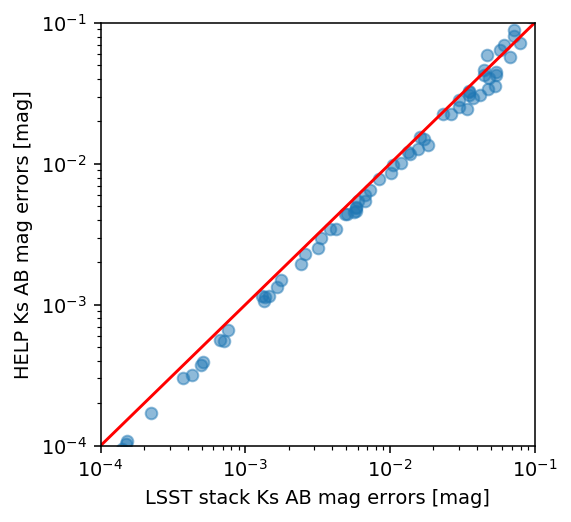

In [52]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['merr_vista_ks'], merge[mask]['help_merr_ap_vista_ks'], alpha=0.5)
plt.xlabel('LSST stack Ks AB mag errors [mag]')
plt.plot([0,1],[0,1], c='r')

plt.xlim([1.e-4,1.e-1])
plt.xscale('log')
#plt.ylim([0,0.1])
plt.ylim([1.e-4,1.e-1])
plt.yscale('log')
plt.ylabel('HELP Ks AB mag errors [mag]')

Text(0, 0.5, 'VISTA pipe Ks AB mag errors [mag]')

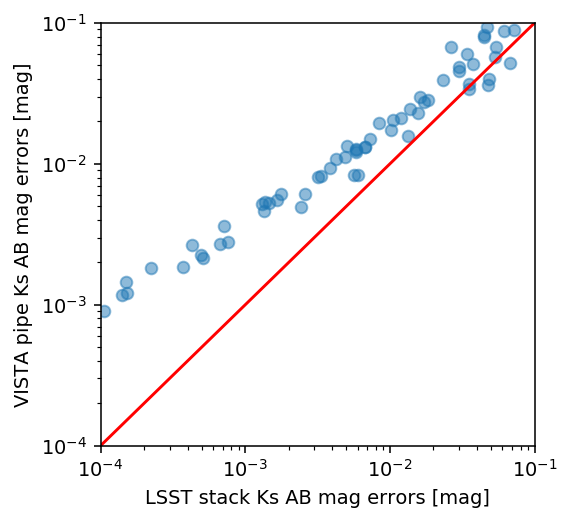

In [53]:
plt.figure(1, figsize=(4, 4), dpi=140)

plt.scatter(merge[mask]['merr_vista_ks'], merge[mask]['ks_tile_merr_vista_ks'], alpha=0.5)
plt.xlabel('LSST stack Ks AB mag errors [mag]')
plt.plot([0,1],[0,1], c='r')
plt.xlim([1.e-4,1.e-1])
plt.xscale('log')
#plt.ylim([0,0.1])
plt.ylim([1.e-4,1.e-1])
plt.yscale('log')
plt.ylabel('VISTA pipe Ks AB mag errors [mag]')

Text(0, 0.5, 'HELP Y AB mag errors [mag]')

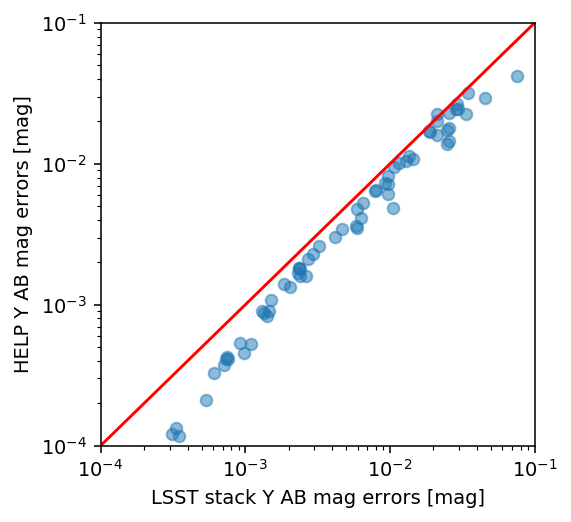

In [54]:
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(merge[mask]['merr_vista_y'], merge[mask]['help_merr_ap_vista_y'], alpha=0.5)
plt.xlabel('LSST stack Y AB mag errors [mag]')
plt.plot([0,1],[0,1], c='r')

plt.xlim([1.e-4,1.e-1])
plt.xscale('log')
#plt.ylim([0,0.1])
plt.ylim([1.e-4,1.e-1])
plt.yscale('log')
plt.ylabel('HELP Y AB mag errors [mag]')

Text(0, 0.5, 'VISTA pipe Y AB mag errors [mag]')

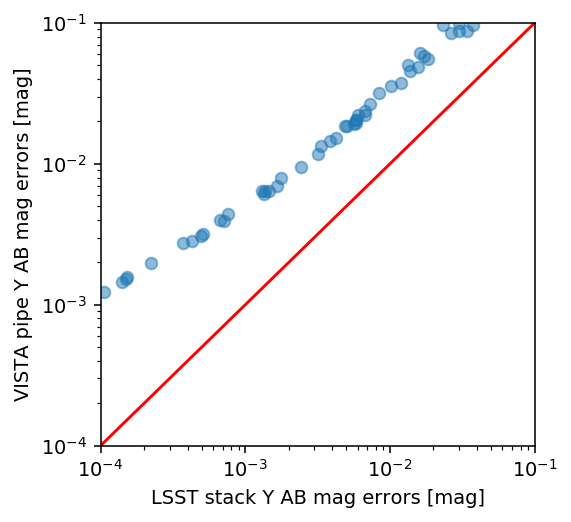

In [55]:
plt.figure(1, figsize=(4, 4), dpi=140)

plt.scatter(merge[mask]['merr_vista_ks'], merge[mask]['y_tile_merr_vista_y'], alpha=0.5)
plt.xlabel('LSST stack Y AB mag errors [mag]')
plt.plot([0,1],[0,1], c='r')
plt.xlim([1.e-4,1.e-1])
plt.xscale('log')
#plt.ylim([0,0.1])
plt.ylim([1.e-4,1.e-1])
plt.yscale('log')
plt.ylabel('VISTA pipe Y AB mag errors [mag]')

### chi squared comparison plots

In [56]:

    
    
from astropy import visualization as vz
import matplotlib
import matplotlib.gridspec as gridspec    

def chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig):
    
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    ax3 = plt.subplot(gs2[:, -1], sharey=ax2)

    
    # Use only finite values
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(xerr) & np.isfinite(yerr)
    x = np.copy(x[mask])
    y = np.copy(y[mask])
    xerr = np.copy(xerr[mask])
    yerr = np.copy(yerr[mask])
    
    # mag1 - mag2
    diff = y - x

    x_label, y_label = labels
    
    # If the difference is all NaN there is nothing to compare.
    if np.isnan(diff).all():
        print("No sources have both {} and {} values.".format(
            x_label, y_label))
        print("")

    # Set the minimum error to 10^-3
    np.clip(xerr, 1e-3, np.max(xerr), out=xerr)
    np.clip(yerr, 1e-3, np.max(yerr), out=yerr)

    # Median, Median absolute deviation and 1% and 99% percentiles
    diff_median = np.median(diff)
    diff_mad = np.median(np.abs(diff - diff_median))
    diff_1p, diff_99p = np.percentile(diff, [1., 99.])
    diff_25p, diff_75p = np.percentile(diff, [25., 75.])
    
    


    print("{} ({} sources):".format(diff_label, len(x)))
    print("- Median: {:.2f}".format(diff_median))
    print("- Median Absolute Deviation: {:.2f}".format(diff_mad))
    print("- 1% percentile: {}".format(diff_1p))
    print("- 99% percentile: {}".format(diff_99p))

    
    # Chi2 (Normalized difference)   
    ichi2 = np.power(diff, 2) / (np.power(xerr, 2) + np.power(yerr, 2))
    
    # Use only non-null values of ichi2
    mask2 = ichi2 != 0.0
    diff, ichi2 = np.copy(diff[mask2]), np.copy(ichi2[mask2])
    x, y, xerr, yerr = np.copy(x[mask2]), np.copy(y[mask2]), np.copy(xerr[mask2]), np.copy(yerr[mask2])

    # Outliers (5sigma)
    log_ichi2_25p, log_ichi2_75p = np.percentile(np.log10(ichi2), [25., 75.])
    out_lim = log_ichi2_75p + 3.2*abs(log_ichi2_25p-log_ichi2_75p)
    
    outliers = np.log10(ichi2) > out_lim 
    nb_outliers = len(x[outliers])
    
    print("Outliers separation: log(chi2) = {:.2f}".format(out_lim))
    print("Number of outliers: {}".format(nb_outliers))

    print("")

    # Comparing mag
    ax1.scatter(x, y, marker='.', alpha=0.1, s=50, color='r')
    ax1.scatter(x[outliers], y[outliers], marker='.', c='b', alpha=0.3, s=50, label='Outliers ({})'.format(nb_outliers))
    min_val = np.min(np.r_[x, y])
    max_val = np.max(np.r_[x, y])
    ax1.autoscale(False)
    ax1.plot([min_val, max_val], [min_val, max_val], "k:")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.legend(loc='lower right', numpoints=1)
    

    # Chi2 vs Diff
    #ax1.set_yscale('log')    # to place before scatter to avoid issues
    ax2.scatter(diff, np.log10(ichi2), marker='.', alpha=0.1, s=50, color='r')
    if nb_outliers != 0:
        ax2.scatter(diff[outliers], np.log10(ichi2[outliers]), marker='.', alpha=0.3, s=50, color='b',\
                        label='Outliers ({})'.format(nb_outliers))
    ax2.axhline(out_lim, color='grey', linestyle=':')
    ax2.set_xlabel(diff_label)
    ax2.set_ylabel('log(chi2)')
    ax2.legend(loc='lower right', numpoints=1)
    
    # Hist
    n, bins, patches = vz.hist(np.log10(ichi2), ax=ax3, bins='knuth', facecolor='red', lw = 2, alpha=0.5,\
                                   orientation="horizontal")
    if nb_outliers > 3:
        n, bins, patches = vz.hist(np.log10(ichi2[outliers]), ax=ax3, bins=bins, facecolor='b', lw = 2, alpha=0.7,\
                                   orientation="horizontal")
    ax3.axhline(out_lim, color='grey', linestyle=':')
    ax3.yaxis.set_tick_params(labelleft=False)
    
    # Save ex. fig


    plt.rc('font', family='serif', serif='Times')
    plt.rc('text') #, usetex=True)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('axes', labelsize=12)



    column_width_cm = 8.9
    width_cm =  2.5* column_width_cm
    hieght_cm = width_cm /2
    width_inches = width_cm/2.5
    hieght_inches = hieght_cm/2.5
    fig.set_size_inches(width_inches, hieght_inches)
    ax1.set_xlim([11, 26])
    ax1.set_ylim([11, 26])
    ax2.set_xlim([-10, 10])
    plt.savefig('./figs/mag_compare.pdf', bbox_inches='tight')
    plt.savefig('./figs/mag_compare.png', bbox_inches='tight')


    survey_label = ((diff_label.replace(" ", "_")).replace("(", "")).replace(")", "")
   
    plt.savefig("./figs/outliers.png" , bbox_inches='tight')
    plt.savefig("./figs/outliers.pdf" , bbox_inches='tight')
    
    
    
    
    
    


No handles with labels found to put in legend.


LSST Stack - HELP [mag] (72 sources):
- Median: 0.47
- Median Absolute Deviation: 0.09
- 1% percentile: 0.16178708409161502
- 99% percentile: 0.9282294633497691
Outliers separation: log(chi2) = 12.17
Number of outliers: 0



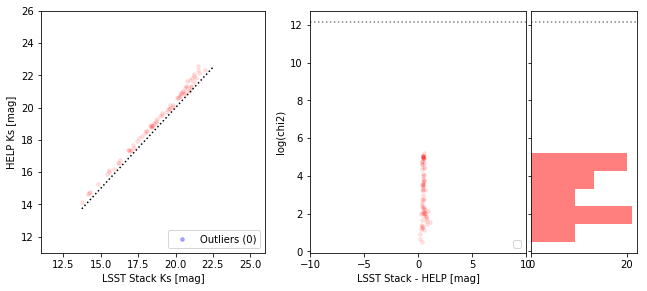

In [57]:
x = merge['m_vista_ks'][mask]
y = merge['help_m_ap_vista_ks'][mask]
xerr = merge['merr_vista_ks'][mask]
yerr = merge['help_merr_ap_vista_ks'][mask]
labels=("LSST Stack Ks [mag]", "HELP Ks [mag]")
diff_label =  "LSST Stack - HELP [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

LSST Stack - HELP [mag] (2249 sources):
- Median: 0.45
- Median Absolute Deviation: 0.35
- 1% percentile: -0.4492137756016808
- 99% percentile: 3.9165408976597837
Outliers separation: log(chi2) = 4.44
Number of outliers: 43



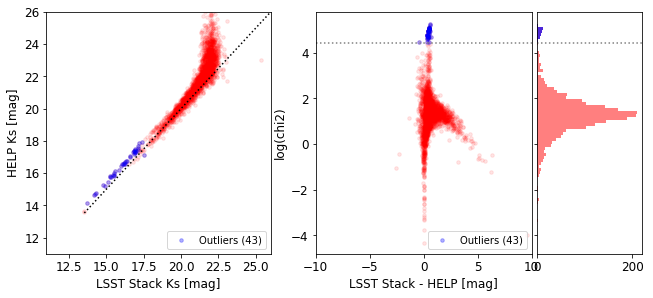

In [58]:
x = merge['m_vista_ks']
y = merge['help_m_ap_vista_ks']
xerr = merge['merr_vista_ks']
yerr = merge['help_merr_ap_vista_ks']
labels=("LSST Stack Ks [mag]", "HELP Ks [mag]")
diff_label =  "LSST Stack - HELP [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack - SExtractor baseline [mag] (2571 sources):
- Median: 0.41
- Median Absolute Deviation: 0.35
- 1% percentile: -0.3194759258403501
- 99% percentile: 4.095589758511406
Outliers separation: log(chi2) = 4.25
Number of outliers: 0



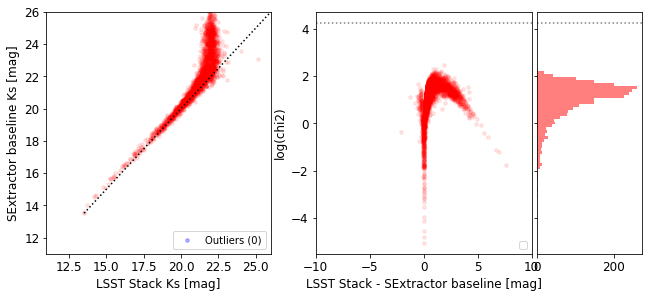

In [73]:
x = merge['m_vista_ks']
y = merge['oxford_ks_m_ap_vista_ks']
xerr = merge['merr_vista_ks']
yerr = merge['oxford_ks_merr_ap_vista_ks']
labels=("LSST Stack Ks [mag]", "Oxford Ks [mag]")
diff_label =  "LSST Stack - Oxford Ks [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Ks - VISTA Ks [mag] (72 sources):
- Median: -0.34
- Median Absolute Deviation: 0.22
- 1% percentile: -1.102826068707774
- 99% percentile: 0.7523828767895833
Outliers separation: log(chi2) = 9.99
Number of outliers: 0



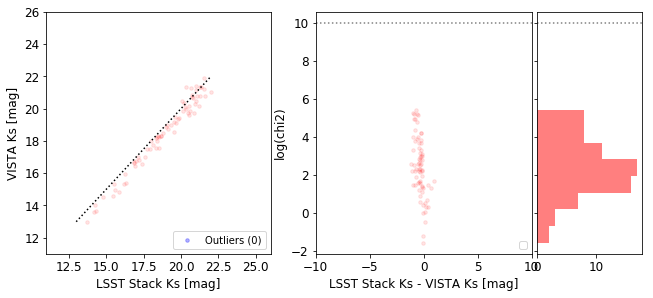

In [59]:
x = merge['m_vista_ks'][mask]
y = merge['ks_tile_m_vista_ks'][mask]
xerr = merge['merr_vista_ks'][mask]
yerr = merge['ks_tile_merr_vista_ks'][mask]
labels=("LSST Stack Ks [mag]", "VISTA Ks [mag]")
diff_label =  "LSST Stack Ks - VISTA Ks [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Ks - VISTA Ks [mag] (72 sources):
- Median: -0.34
- Median Absolute Deviation: 0.22
- 1% percentile: -1.102826068707774
- 99% percentile: 0.7523828767895833
Outliers separation: log(chi2) = 9.99
Number of outliers: 0



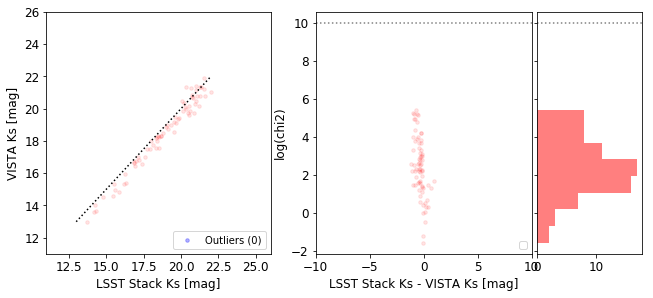

In [60]:
x = merge['m_vista_ks'][mask]
y = merge['ks_tile_m_vista_ks'][mask]
xerr = merge['merr_vista_ks'][mask]
yerr = merge['ks_tile_merr_vista_ks'][mask]
labels=("LSST Stack Ks [mag]", "VISTA Ks [mag]")
diff_label =  "LSST Stack Ks - VISTA Ks [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Y - HELP Y [mag] (72 sources):
- Median: 0.31
- Median Absolute Deviation: 0.07
- 1% percentile: 0.022862636246107
- 99% percentile: 0.5499675769280261
Outliers separation: log(chi2) = 10.76
Number of outliers: 0



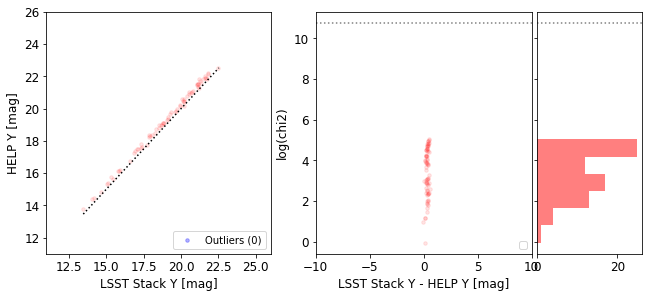

In [61]:
x = merge['m_vista_y'][mask]
y = merge['help_m_ap_vista_y'][mask]
xerr = merge['merr_vista_y'][mask]
yerr = merge['help_merr_ap_vista_y'][mask]
labels=("LSST Stack Y [mag]", "HELP Y [mag]")
diff_label =  "LSST Stack Y - HELP Y [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Y - HELP Y [mag] (2188 sources):
- Median: 0.11
- Median Absolute Deviation: 0.25
- 1% percentile: -4.061946056787064
- 99% percentile: 2.0000015853615247
Outliers separation: log(chi2) = 6.43
Number of outliers: 0



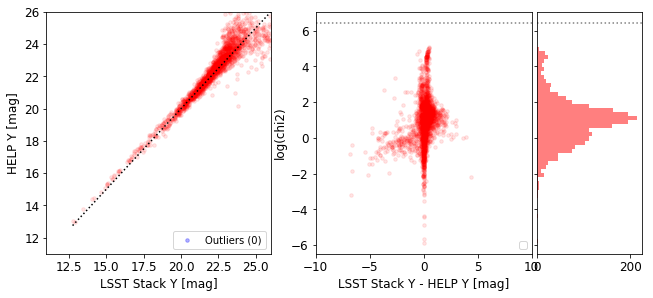

In [62]:
x = merge['m_vista_y']
y = merge['help_m_ap_vista_y']
xerr = merge['merr_vista_y']
yerr = merge['help_merr_ap_vista_y']
labels=("LSST Stack Y [mag]", "HELP Y [mag]")
diff_label =  "LSST Stack Y - HELP Y [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Y - VISTA tile Y [mag] (66 sources):
- Median: -1.63
- Median Absolute Deviation: 0.25
- 1% percentile: -2.669145325033364
- 99% percentile: -0.747183865454793
Outliers separation: log(chi2) = 12.50
Number of outliers: 0



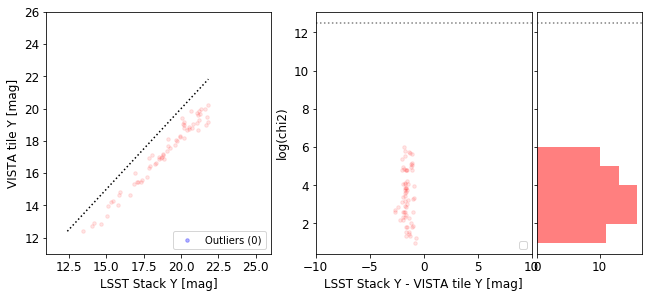

In [63]:
x = merge['m_vista_y'][mask]
y = merge['y_tile_m_vista_y'][mask]
xerr = merge['merr_vista_y'][mask]
yerr = merge['y_tile_merr_vista_y'][mask]
labels=("LSST Stack Y [mag]", "VISTA tile Y [mag]")
diff_label =  "LSST Stack Y - VISTA tile Y [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)

No handles with labels found to put in legend.


LSST Stack Y - VISTA tile Y [mag] (1226 sources):
- Median: -2.72
- Median Absolute Deviation: 0.35
- 1% percentile: -7.181193446309055
- 99% percentile: -0.9932712383334357
Outliers separation: log(chi2) = 7.23
Number of outliers: 0



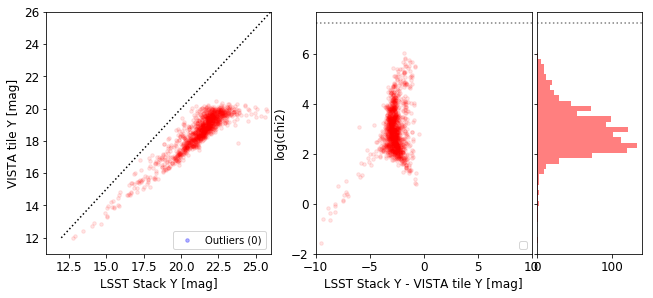

In [64]:
x = merge['m_vista_y']
y = merge['y_tile_m_vista_y']
xerr = merge['merr_vista_y']
yerr = merge['y_tile_merr_vista_y']
labels=("LSST Stack Y [mag]", "VISTA tile Y [mag]")
diff_label =  "LSST Stack Y - VISTA tile Y [mag]" # "{} - {}".format(y_label, x_label)
savefig=True
chi2_plots(x,y,xerr,yerr, labels,diff_label, savefig)